In [31]:
import scanpy as sc
import scvi
import scipy

sc.set_figure_params(figsize=(5, 5))

In [32]:
adata = sc.read_h5ad('../output/cv_zonation.h5ad')
adata.X = scipy.sparse.csr_matrix(adata.X)

In [33]:
#Store full feature space for counts
adata.uns["all_counts"] = adata.X.copy()

In [34]:
#Preprocess
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [35]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True
)

In [36]:
#scVI
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="time"
)

vae = scvi.model.SCVI(adata, n_layers=2, 
                      encode_covariates=True,
                      deeply_inject_covariates=False,
                      use_layer_norm="both",
                      use_batch_norm="none"
)

vae.train(max_epochs=400,
          early_stopping=True,
          early_stopping_monitor='elbo_validation',
          early_stopping_patience=10
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 115/400:  29%|██     | 115/400 [03:12<07:57,  1.68s/it, loss=627, v_num=1]
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 664.682. Signaling Trainer to stop.


In [37]:
#Save model
vae.save("../output/scVI_cv_zonation",
          overwrite=True)

In [38]:
# Embed using scVI latent space
adata.obsm["X_scVI"] = vae.get_latent_representation()

adata.layers["scvi_normalized"] = vae.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [52]:
#Cluster
sc.tl.leiden(adata, key_added="leiden", resolution=0.2)

/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


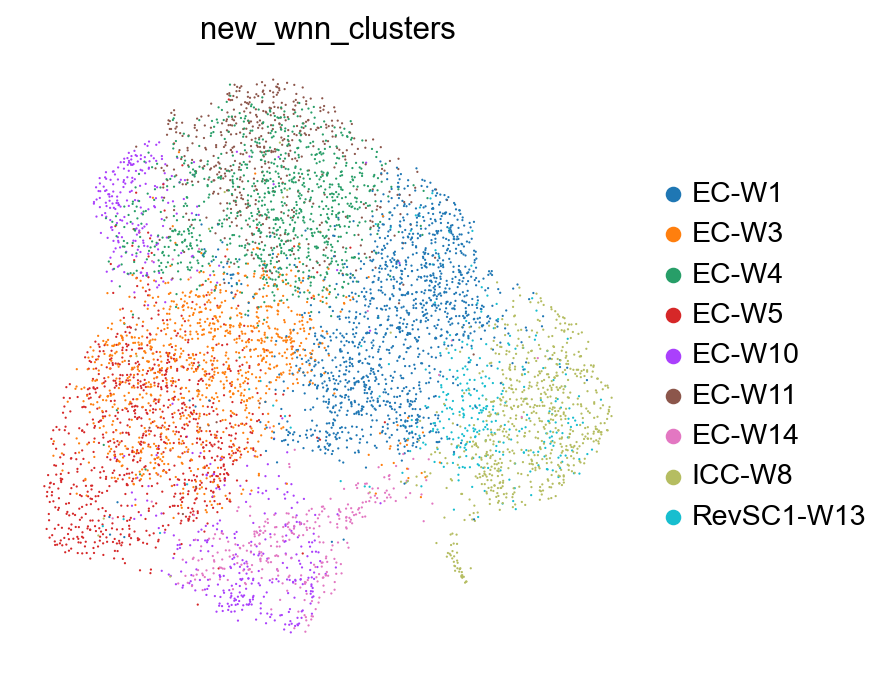

In [53]:
sc.pl.umap(adata,
          color='new_wnn_clusters',
          frameon=False,
          size=4)

/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scat

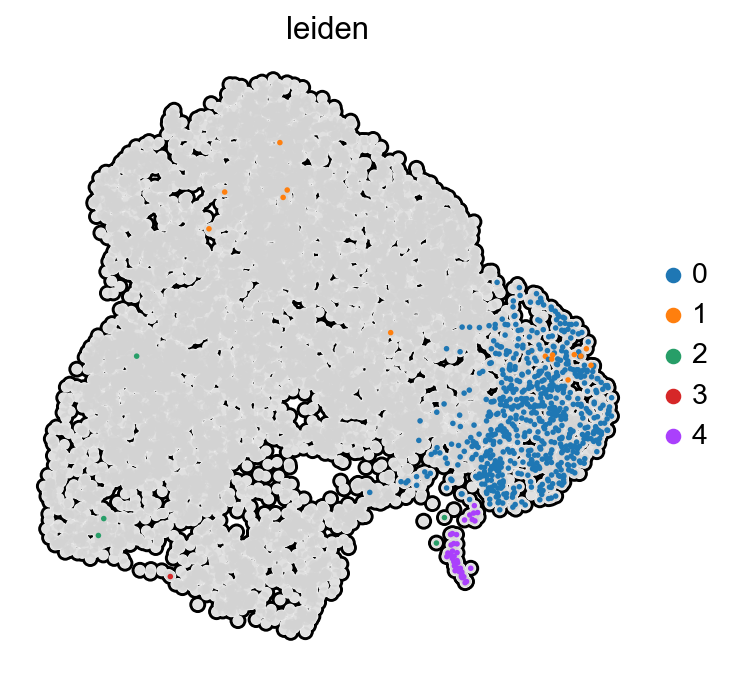

In [65]:
ax = sc.pl.umap(adata, size=80, show=False, add_outline=True, frameon=False)
sc.pl.umap(
    adata[adata.obs["new_wnn_clusters"] == "ICC-W8"],
    size=25,
    color="leiden",
    frameon=False,
    ax=ax
)

/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


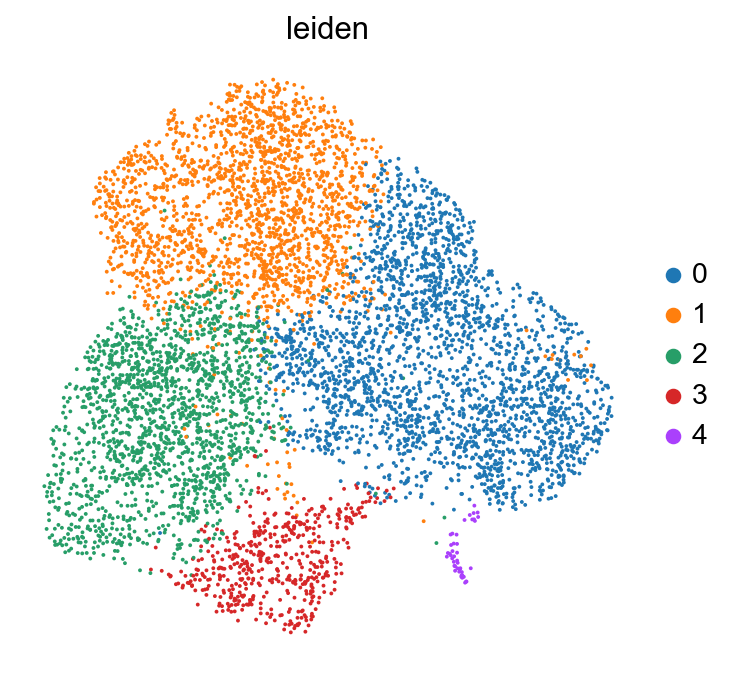

In [54]:
sc.pl.umap(adata,
          color='leiden',
          frameon=False,
          size=12)

In [42]:
sc.tl.embedding_density(adata, groupby="time")

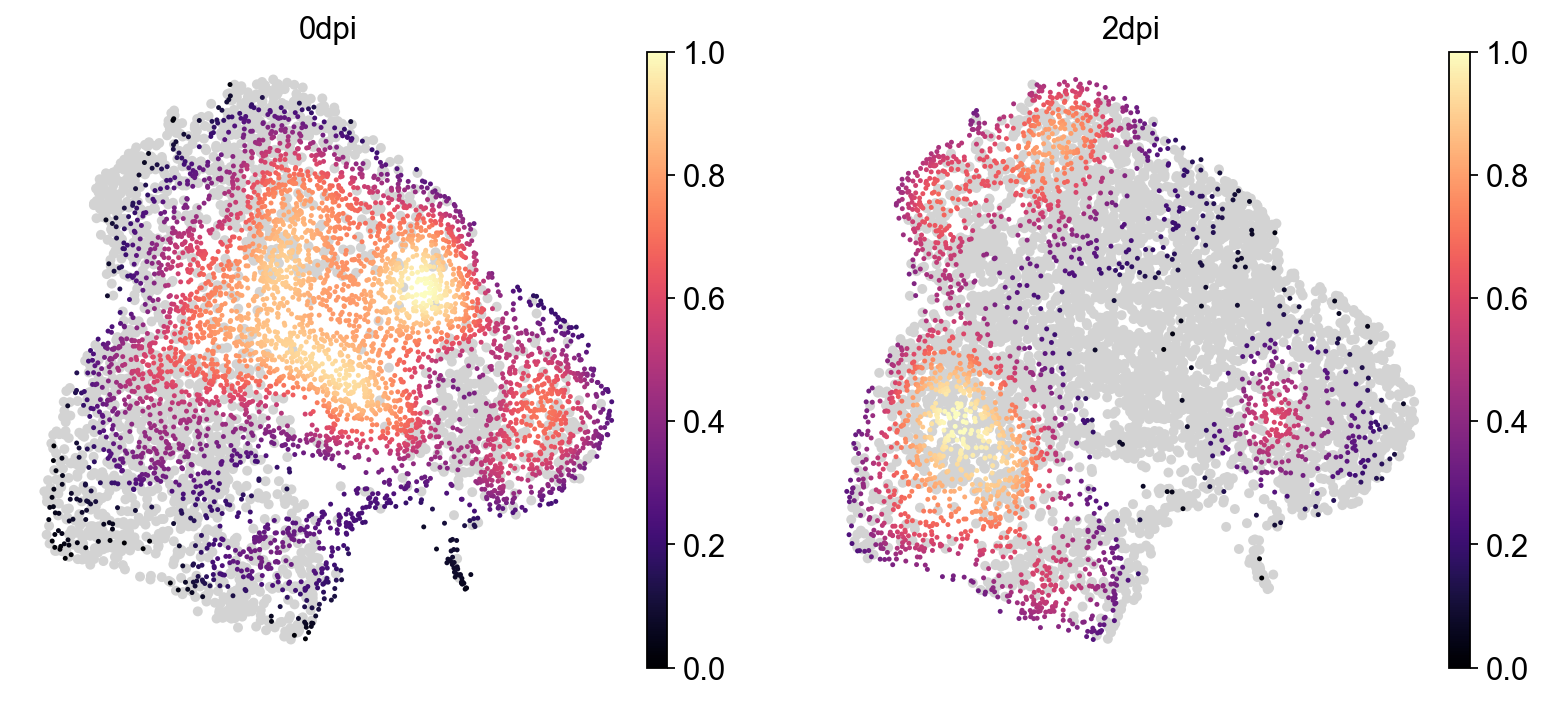

In [43]:
sc.pl.embedding_density(adata, groupby="time",
                       color_map='magma', fg_dotsize=20, frameon=False)

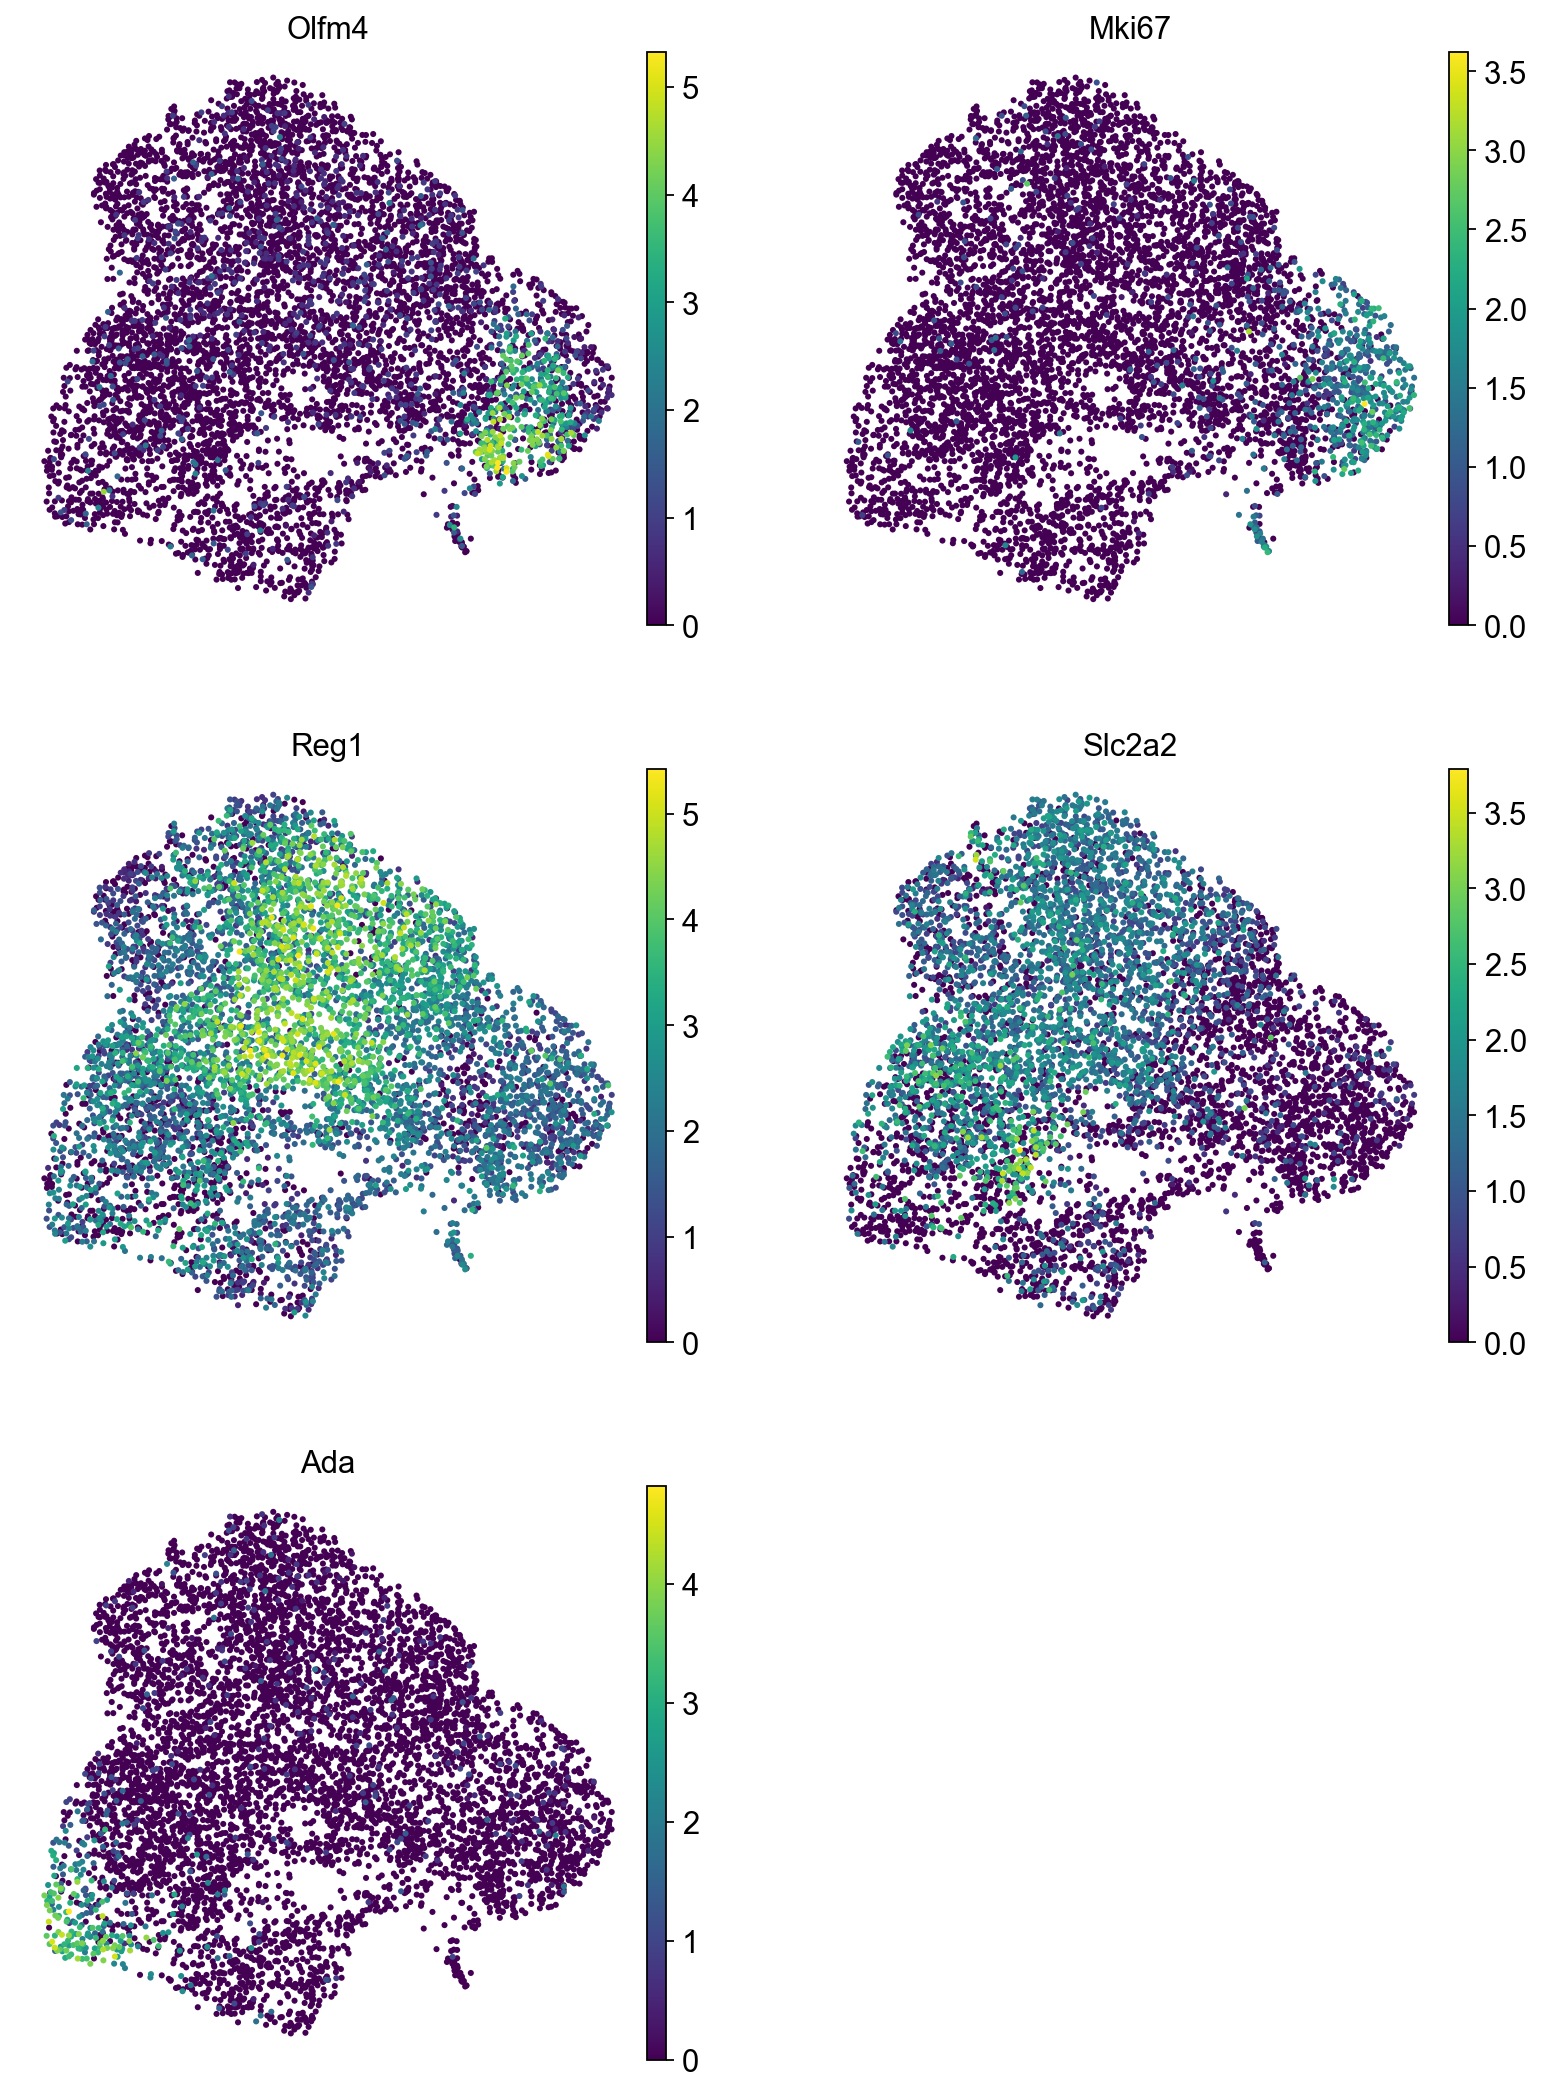

In [66]:
sc.pl.umap(adata,
          color=['Olfm4', 'Mki67', 'Reg1', 'Slc2a2', 'Ada'],
           ncols=2,
           size=30,
          frameon=False)

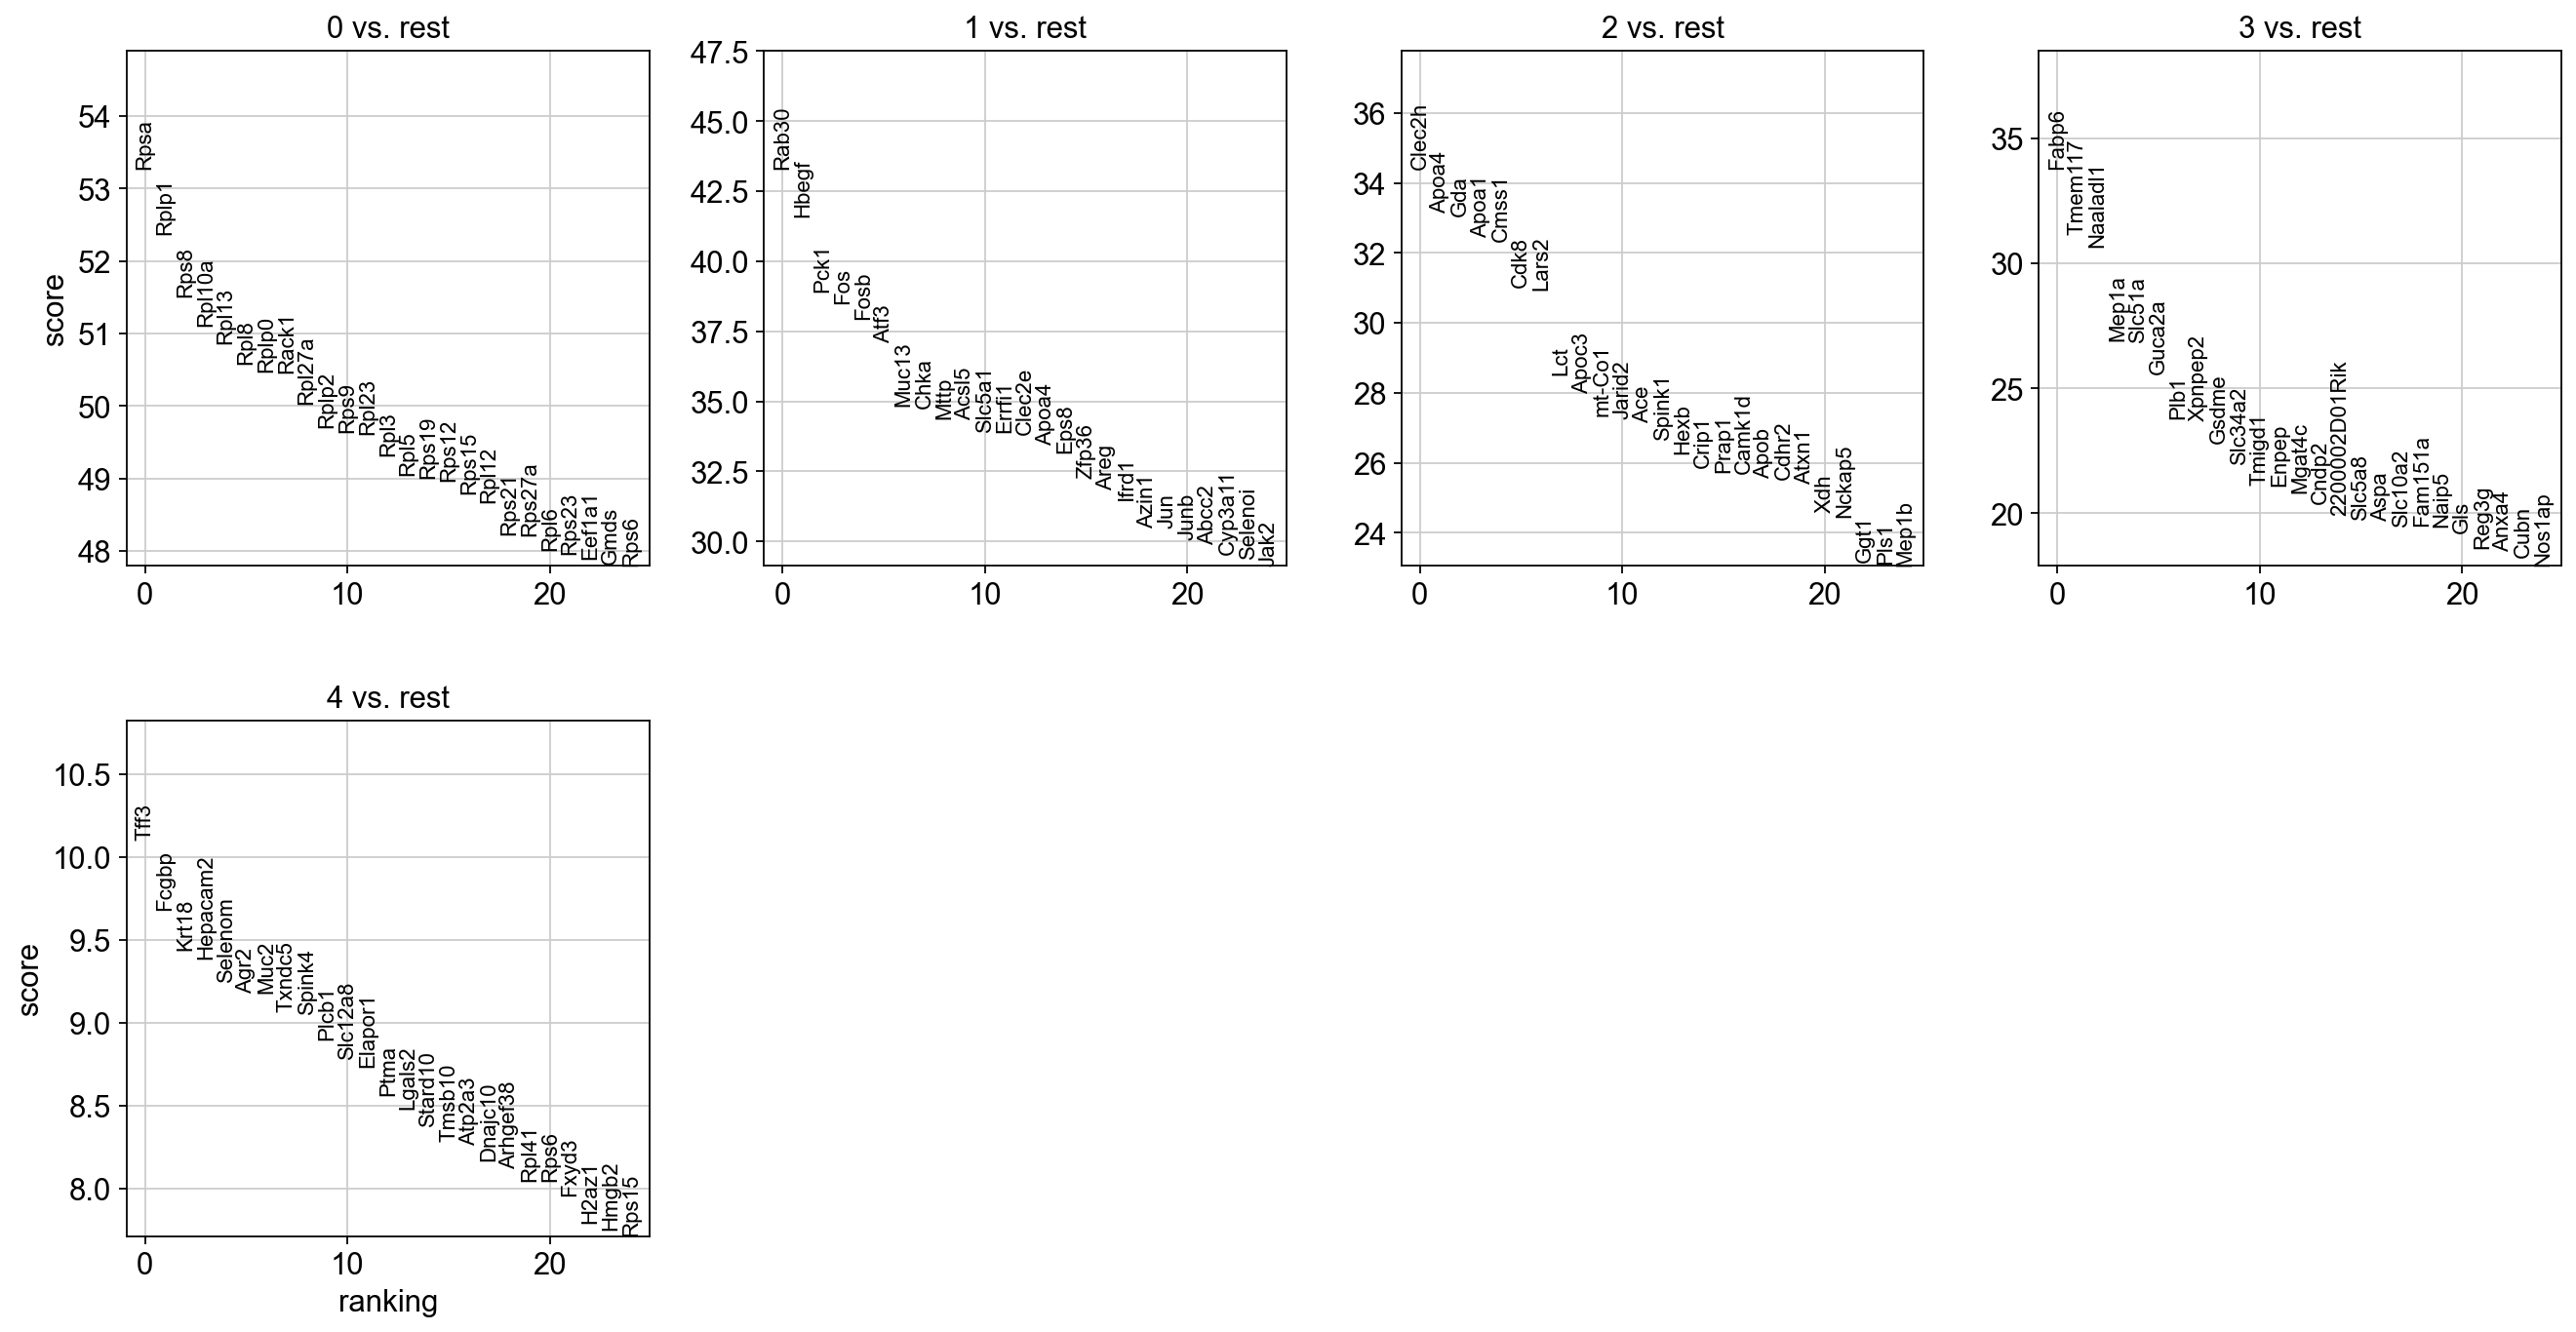

In [56]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon", fontsize=10)

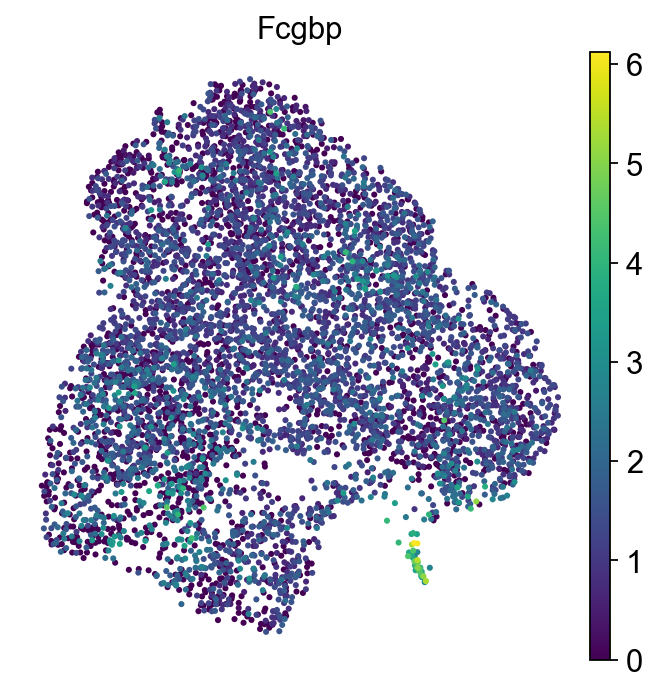

In [58]:
sc.pl.umap(adata,
          color=['Fcgbp'],
           ncols=2,
           size=30,
          frameon=False)

In [67]:
adata.write_h5ad('../output/rna_preprocessed_d0_d2.h5ad')

# Subset cells
Cluster 4 is an alternative lineage that is exclusive to villi of the ileum. This is based on exploring the Haber et al data set that had regionally separated data

Cluster 5 appears to be goblet cell doublets


In [68]:
adata = adata[-adata.obs['leiden'].isin(['3', '4'])]

In [69]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [79]:
#Cluster
sc.tl.leiden(adata, key_added="leiden", resolution=0.1)

/Users/dpcook/mambaforge/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


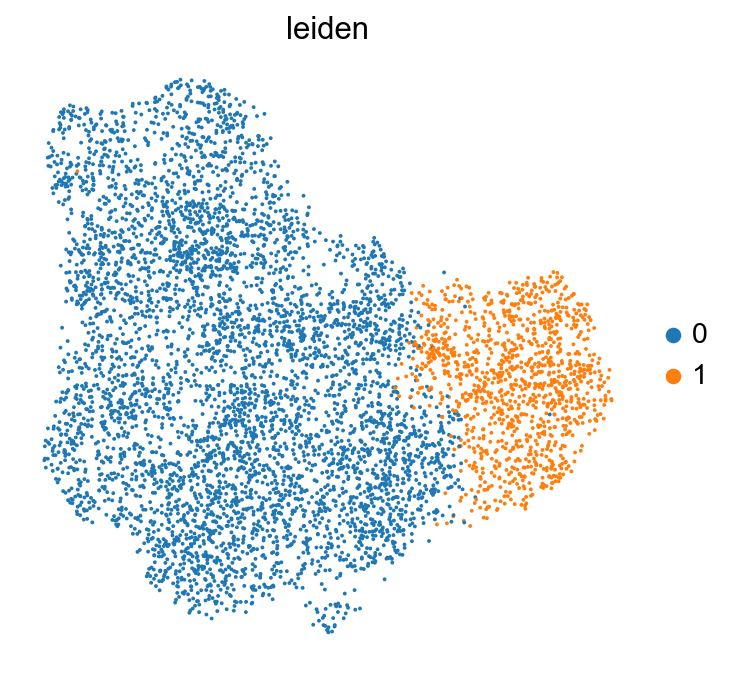

In [80]:
sc.pl.umap(adata,
          color='leiden',
           size=12,
          frameon=False)
         # size=60)

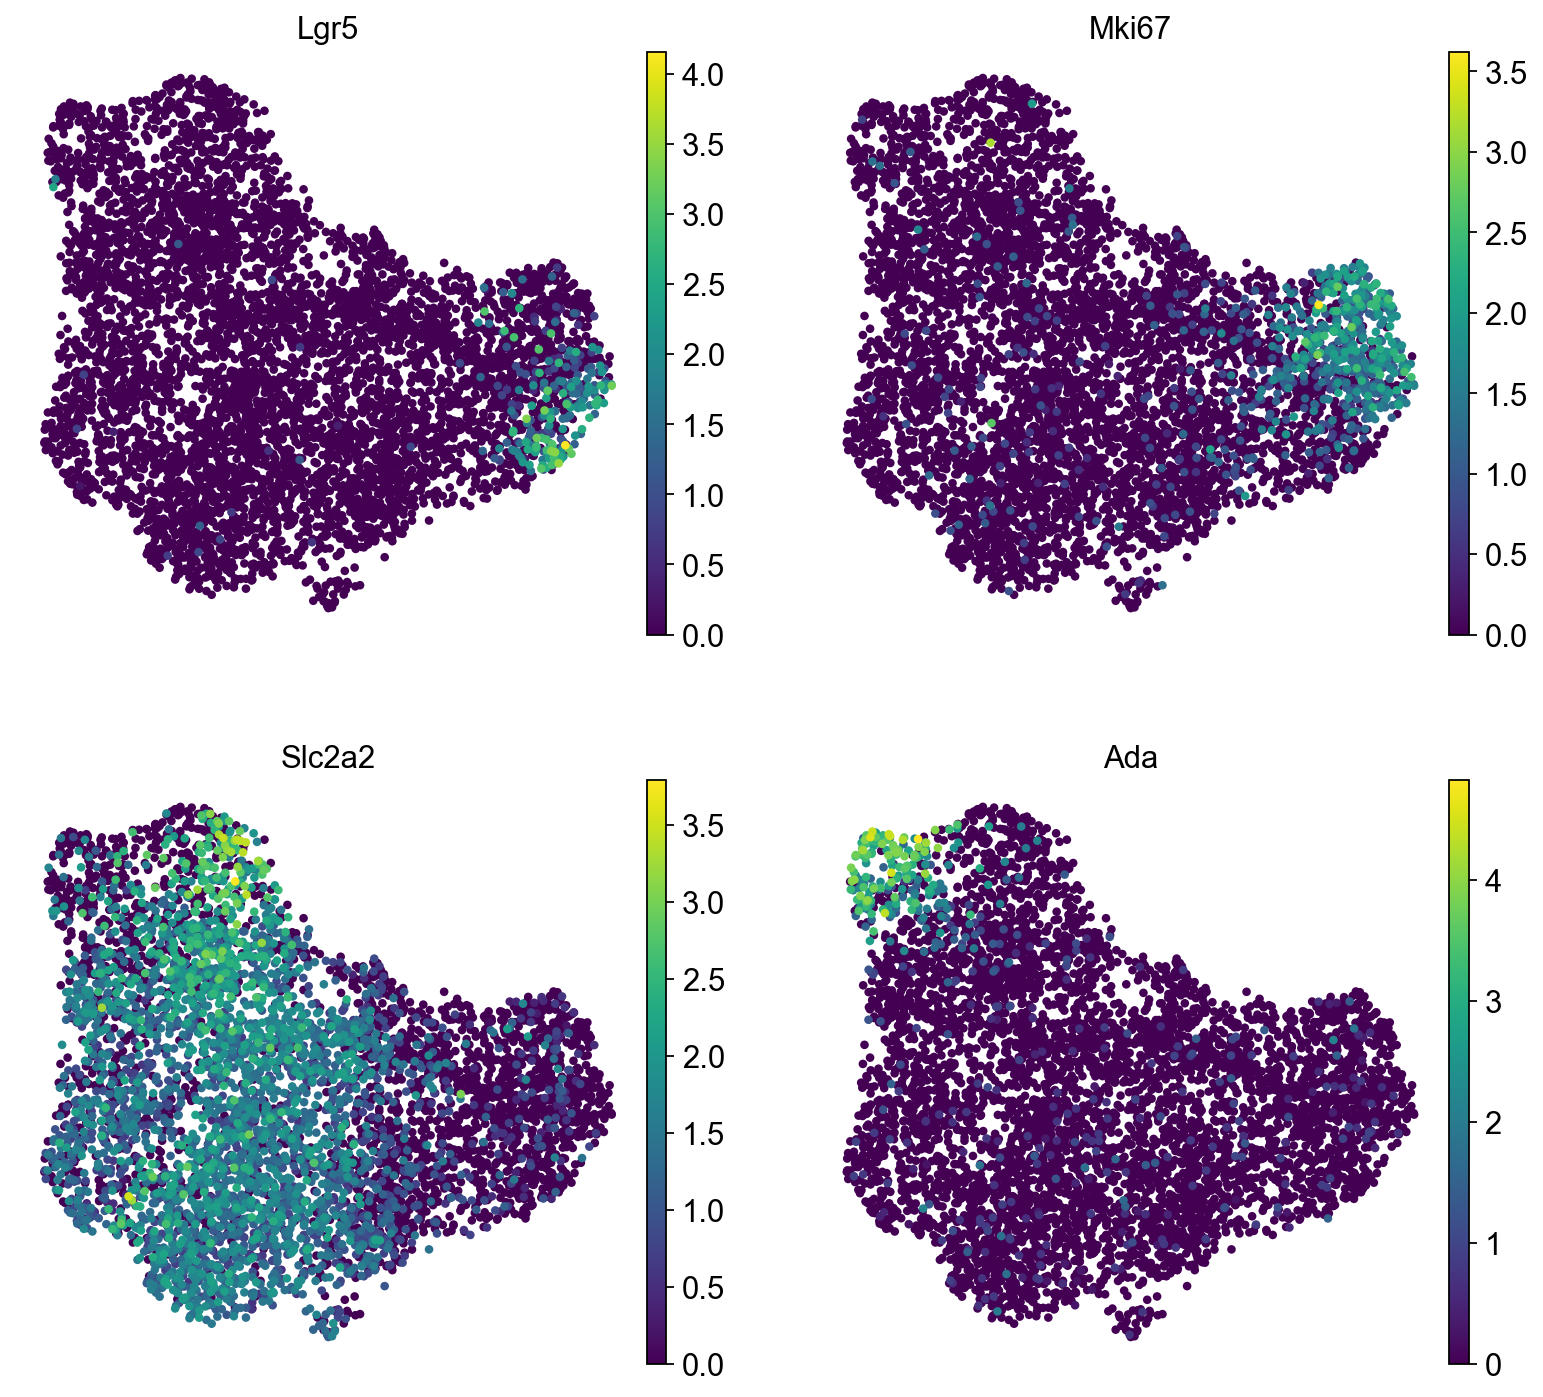

In [72]:
sc.pl.umap(adata,
          color=['Lgr5', 'Mki67', 'Slc2a2', 'Ada'],
           ncols=2,
           size=60,
          frameon=False)

In [73]:
sc.tl.embedding_density(adata, groupby='time')

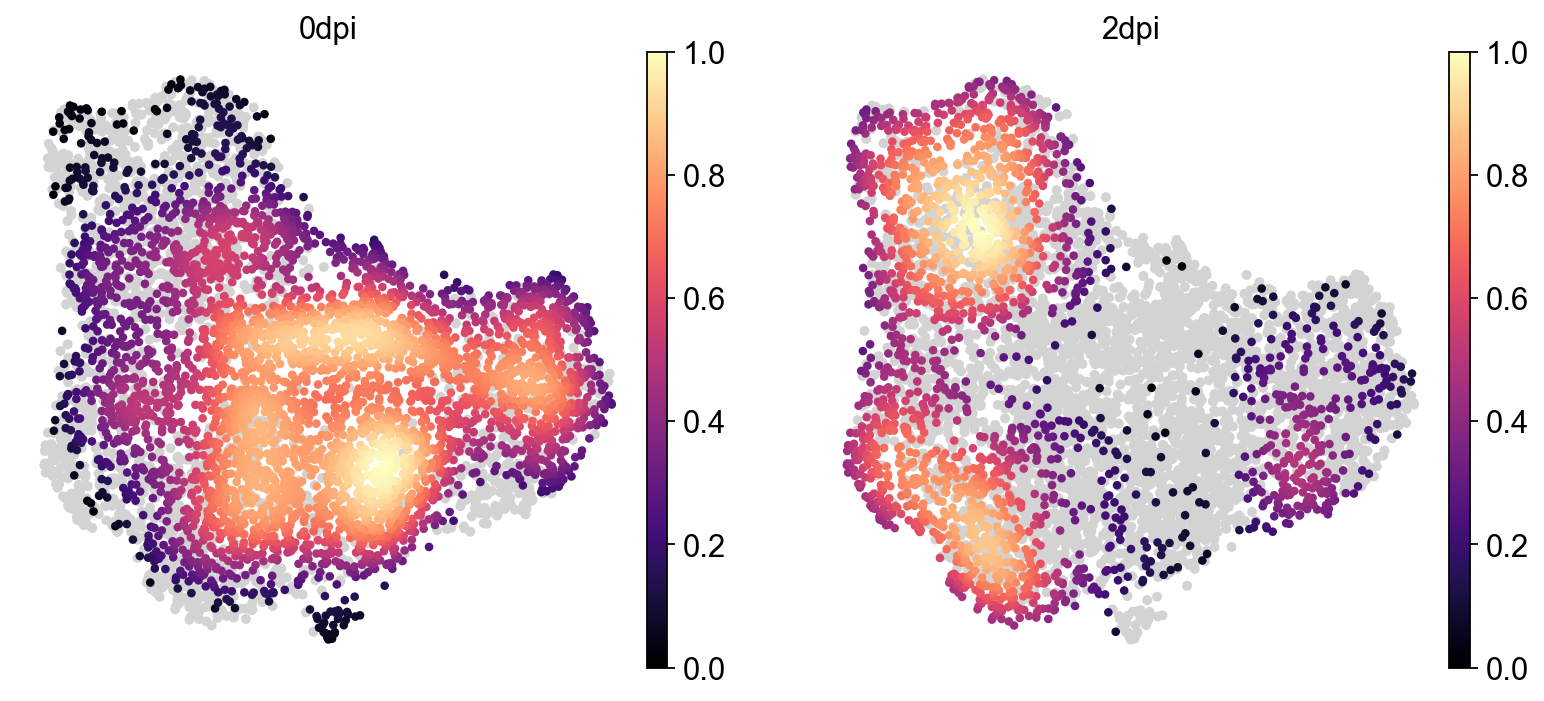

In [74]:
sc.pl.embedding_density(adata, groupby="time",
                       color_map='magma', fg_dotsize=60, frameon=False)

In [75]:
adata.write_h5ad('../output/cv_zonation_integrated.h5ad')

# Export some metadata

In [81]:
adata.obs.to_csv('../output/rna_metadata.csv')

In [82]:
import pandas as pd
embed = pd.DataFrame(adata.obsm['X_umap'], columns=['scVI_1', 'scVI_2'])

In [83]:
embed.to_csv('../output/integrated_embedding.csv')